In [1]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, ElasticNet
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, RocCurveDisplay, roc_curve, auc
#from sklearn.linear_model import LassoCV, Lasso
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer



In [2]:
#!pip install lifelines

In [3]:
counts = pd.read_csv("count_500most.csv", index_col = 0)  #counts_231#raw count of the most variable genes 
meta = pd.read_csv("meta_500most.csv", index_col = 2)  #meta data associated to the raw counts

# import clinical data forliver  downloaded from cBioportal
clinical_df = pd.read_csv("lihc_tcga_pan_can_atlas_2018_clinical_data.tsv", delimiter='\t', index_col=2)  # used column 3 (sample_ID as the rownames)

clinical_df.drop(clinical_df.columns[0], axis=1, inplace=True) #drops the first column and modifies the dataset inplace

meta.drop(meta.columns[0], axis=1, inplace=True)


(500, 338)

In [4]:
## Check if there are no duplicate rows and column. If they exist, drop one.
print("There are duplicate rows:{}".format(counts.index.duplicated().any()))
print("There are duplicate columns:{} \n".format(counts.columns.duplicated().any()))\
    
#remove duplicate columns
counts = counts.loc[:, ~counts.columns.duplicated()]
counts = counts.loc[~counts.index.duplicated(),:]

counts.shape

There are duplicate rows:True
There are duplicate columns:False 



(492, 338)

In [5]:
clinical_df_subset = clinical_df[['Disease Free (Months)', 'Disease Free Status', 'American Joint Committee on Cancer Tumor Stage Code']].copy()
clinical_df_subset = clinical_df_subset.rename(columns={
    'Disease Free (Months)': 'Time',
    'Disease Free Status': 'Status',
    'American Joint Committee on Cancer Tumor Stage Code': 'Tumor_Stage'
})

clinical_df_subset['Status'] = clinical_df_subset['Status'].replace({'0:DiseaseFree': 0, '1:Recurred/Progressed': 1})

df = clinical_df_subset.dropna().copy()




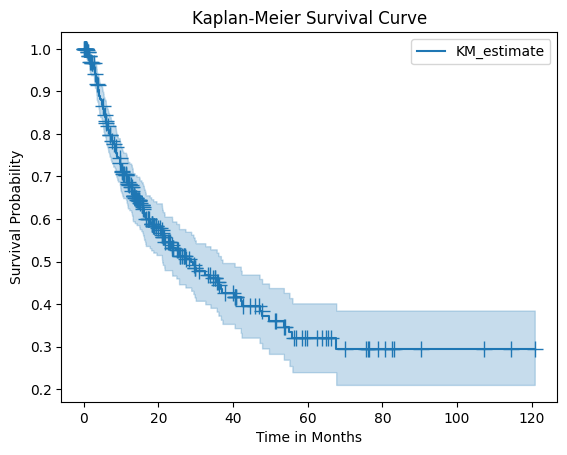

In [6]:
# Create a Kaplan-Meier estimator
kmf = KaplanMeierFitter()

# Fit the model
kmf.fit(durations=df['Time'], event_observed=df['Status'])

# Plot the survival curve
kmf.plot_survival_function(show_censors=True)
plt.title('Kaplan-Meier Survival Curve')
plt.xlabel('Time in Months')
plt.ylabel('Survival Probability')
plt.show()

# Survival Analysis Stratified By Tumor Stage

In [7]:
def plot_survival_curves_by_tumor_stage(dataframe, time_col, status_col, tumor_stage_col):
    """
    Plot Kaplan-Meier survival curves stratified by tumor stage.

    Parameters:
    - dataframe: Pandas DataFrame containing the survival data.
    - time_col: Name of the column representing time (duration).
    - status_col: Name of the column representing event/censoring indicator (0 for event-free, 1 for event).
    - tumor_stage_col: Name of the column representing tumor stage.

    Returns:
    None (displays the plot).
    """
    # Create a Kaplan-Meier estimator
    kmf = KaplanMeierFitter()

    # Stratify by tumor stage
    tumor_stages = dataframe[tumor_stage_col].unique()
    # Set a seaborn color palette for the tumor stages
    sns.set_palette("husl", n_colors=len(tumor_stages))

    # Plot survival curves for each tumor stage
    plt.figure(figsize=(10, 6))
    for i, stage in enumerate(tumor_stages):
        subset = dataframe[dataframe[tumor_stage_col] == stage]
        kmf.fit(durations=subset[time_col], event_observed=subset[status_col], label=stage)
        kmf.plot_survival_function(show_censors = True, color=sns.color_palette()[i])

    #plt.title('Disease Free Survival Curve Stratified by Tumor Stage')
    plt.xlabel('Time (in months)', fontsize=12, fontweight = "bold")
    plt.ylabel('Survival Probability', fontsize=12, fontweight = "bold")
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='Tumor Stage')
    plt.show()


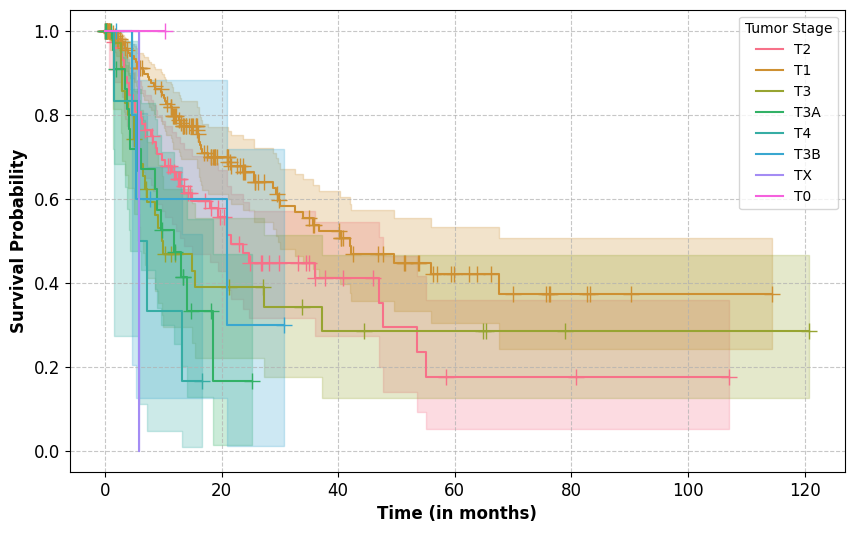

In [8]:
plot_survival_curves_by_tumor_stage(df, 'Time', 'Status', 'Tumor_Stage')

## Create Recurrence Variable From Disease Free Survival Curve

In [9]:
#Add a new variable "recurrence class" to "clinical df" based on the disease free survival curve
# Time threshold
T1 = clinical_df_subset['Time'].quantile(0.25)
T2 = clinical_df_subset['Time'].quantile(0.75)

# Filter out rows where 'Time' is between T1 and T2
clinical_df_subset = clinical_df_subset[(clinical_df_subset['Time'] <= T1) | (clinical_df_subset['Time'] >= T2)]

clinical_df_subset['recurrence_class'] = 'Long Survival'
clinical_df_subset.loc[clinical_df_subset['Time'] <= T1, 'recurrence_class'] = 'Short Survival'

# clinical_df_subset['recurrence_class'] = 'Short Survival'
# clinical_df_subset.loc[clinical_df_subset['Time'] > T1, 'recurrence_class'] = 'Intermediate Survival'
# clinical_df_subset.loc[clinical_df_subset['Time'] > T2, 'recurrence_class'] = 'Long Survival'

In [10]:
clinical_df_subset['Tumor_Stage'].value_counts().unique

<bound method Series.unique of T1     84
T2     41
T3     20
T3A    10
T3B     4
T4      2
Name: Tumor_Stage, dtype: int64>

In [11]:
count_new = counts.T

common_row_names = set(clinical_df_subset.index) & set(count_new.index) #checks for rownames that are the same 
len(common_row_names)

143

### subset clinical_df.

In [13]:
count_new_filtered = count_new[count_new.index.isin(common_row_names)]
clinical_df_subset_filtered = clinical_df_subset[clinical_df_subset.index.isin(common_row_names)]
meta_filtered = meta[meta.index.isin(common_row_names)]

In [14]:
# Reindex the clinical_df_subset_filtered based on the order of count_new_filtered's row names
clinical_df_subset_filtered = clinical_df_subset_filtered.reindex(count_new_filtered.index)
#print((clinical_df_subset_filtered.index == count_new_filtered.index).all())

count_new_filtered = count_new_filtered.copy()

# Add 'Tumor stage' and 'recurrence_class' columns from clinical_df_subset_filtered to count_new_filtered
count_new_filtered['Tumor_Stage'] = clinical_df_subset_filtered['Tumor_Stage']
count_new_filtered['recurrence_class'] = clinical_df_subset_filtered['recurrence_class']
#count_new_filtered['Tumor_Stage'] = meta_filtered['tumor_stage']
count_new_filtered['age_quartile'] = meta_filtered['age_quartile']

## Building the model

In [16]:
def preprocess_data(data, target_columns, features_to_drop=None):
    # Separate features and target variable
    X = data.drop([target_columns], axis=1)
    y = data[target_columns]

    # Drop specified features if provided
    if features_to_drop:
        X = X.drop(features_to_drop, axis=1)
        
    numeric_col = X.select_dtypes(include='number').columns.tolist()
    categorical_col = X.select_dtypes(exclude='number').columns.tolist()

    # Label encode the target variable y
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Access the mapping between original values and encoded values
    mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))


    return X, y_encoded, numeric_col, categorical_col, mapping

In [17]:
def train_model(X_train, y_train, model_class, numeric_features, 
                categorical_features=None, param_grid=None, max_iter=None, cv=5, nrepeats=3):
    """
    Train a machine learning model using GridSearchCV with cross-validation and also plots the roc-auc curve.

    Parameters:
    - X_train: Training features DataFrame
    - y_train: Training target variable
    - model_class: The model class to be used in the pipeline (e.g., LogisticRegression, RandomForestClassifier)
    - numeric_features: List of numeric feature column names
    - categorical_features: List of categorical feature column names
    - param_grid: Dictionary with hyperparameter values for GridSearchCV
    - max_iter: maximum iteration
    - cv: Number of folds for cross-validation
    - nrepeates: Number of repeats for each fold

    Returns:
    - best_model: Fitted model with the best hyperparameters
    - grid_result: Results of the grid search
    - roc_curves: List of ROC curves for each fold
    """

    # Create transformers based on feature types
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('encoder', OrdinalEncoder(categories=[
            ['T1', 'T2', 'T3', 'T3A', 'T3B', 'T4'],
            #['16-50', '51-60','61-68','69-90']
            ]))
    ])

    # ColumnTransformer applies transformers based on feature types
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features) if categorical_features else ('passthrough', 'passthrough', [])
        ]
    )

    # Create a pipeline with the provided model class
    model_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model_class(random_state=42))
    ])

    # StratifiedKFold for cross-validation
    kf = RepeatedStratifiedKFold(n_splits=cv, n_repeats=nrepeats, random_state=42)

    # GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(model_pipeline, param_grid, cv=kf, scoring='accuracy', return_train_score=True, error_score=0, n_jobs=-1)
    grid_result = grid_search.fit(X_train, y_train)

    # best model from the grid search
    best_model = grid_result.best_estimator_

    # Get the ROC curves for each fold
    roc_curves = []

    # Create a single figure for all ROC curves
    plt.figure(figsize=(8, 6))

    for i, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

        # Fit the best model on the training fold
        best_model.fit(X_train_fold, y_train_fold)

        # Check if the model is LinearSVC
        if model_class == LinearSVC:
            # For LinearSVC, use decision_function instead of predict_proba
            decision_values = best_model.decision_function(X_test_fold)
            fpr, tpr, _ = roc_curve(y_test_fold, decision_values)
        else:
            # For other models, use predict_proba
            y_probs = best_model.predict_proba(X_test_fold)[:, 1]
            fpr, tpr, _ = roc_curve(y_test_fold, y_probs)
            
        roc_auc = auc(fpr, tpr)  #calculate roc

        # Save ROC curve data for later use if needed. I mostly won't need this
        roc_curves.append((fpr, tpr))

        # Plot the ROC curve for the current fold
        plt.plot(fpr, tpr, label=f'Fold {i + 1} (AUC = {roc_auc:.2f})')

    # Plot the random classifier line
    plt.plot([0, 1], [0, 1], 'k--', label='Random')

    plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold') 
    plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')   
    plt.title('ROC Curve for Each Fold', fontsize=16, fontweight='bold')  
    plt.xticks(fontsize=12, fontweight='bold') 
    plt.yticks(fontsize=12, fontweight='bold')  
    plt.legend(fontsize=12) 

    return best_model, grid_result, roc_curves


In [18]:
def print_grid_search_results(best_model, grid_result):
    """
    Print the best parameters, and best score from a grid search.

    Parameters:
    - best_model: The best model obtained from the grid search.
    - grid_result: The grid search result object.

    Prints:
    - Best parameters, best score.
    """
    print("Best Parameters: \n", grid_result.best_params_,"\n")
    print("Best Score:\n", grid_result.best_score_ )


In [19]:
def generate_classification_report(true_labels, predicted_labels, model_name="Model"):
    """
    Generate a classification report.

    Parameters:
    - true_labels: True labels of the data
    - predicted_labels: Predicted labels of the data
    - model_name: Name of the model (default is "Model")

    Returns:
    - report: Classification report
    """
    report = classification_report(true_labels, predicted_labels, target_names = ['Long Survival', 'Short Survival'])
    print(f"Classification Report ({model_name}):\n", report)
    return None


In [20]:
def plot_roc_auc_test(y_true, y_predicted, estimator_name):
    fpr, tpr , _ = roc_curve(y_true, y_predicted)
    roc_auc = auc(fpr,tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                 estimator_name=estimator_name)
    display.plot()
    plt.show()

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def display_confusion_matrix(true_labels, predicted_labels, model_name="Model"):
    """
    Display the confusion matrix.

    Parameters:
    - true_labels: True labels of the data
    - predicted_labels: Predicted labels of the data
    - model_name: Name of the model (default is "Model")
    """
    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels = [0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Long Survival', 'Short Survival'])
    # Create a figure and axes
    fig, ax = plt.subplots()
    ax.tick_params(axis='both', which='both', labelsize=14)
    ax.set_xlabel('Predicted Label', fontsize=14, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=14, fontweight='bold')

    disp.plot(ax=ax)
    
    # Display the model name as the title
    #plt.title(f'Confusion Matrix for {model_name}', fontsize=12, fontweight='bold')




In [22]:
def get_selected_features_from_classifier(best_model, features_names):
    """
    Extract and return selected features from a classifier if applicable.

    Parameters:
    - best_model: The best model obtained from a pipeline
    - features_names: A list of feature names.

    Returns:
    - selected_features: A list of selected feature names (if applicable), or None.
    """
    # Access the classifier from the best model
    classifier = best_model.named_steps.get('classifier')

    # Check if the classifier has coefficients
    if classifier and hasattr(classifier, 'coef_'):
        # Get the coefficients and find non-zero coefficients
        coefficients = classifier.coef_
        selected_features_indices = (coefficients != 0).any(axis=0)
        selected_features = np.array(features_names)[selected_features_indices]

        return selected_features.tolist()

    # Return None if the model or coefficients are not applicable
    return None


## With Genes as the only fetaures 

In [23]:
# X = count_new_filtered.drop(["recurrence_class"], axis=1)
# y = count_new_filtered["recurrence_class"]

X, y, numeric_features, categorical_features, y_mapping = preprocess_data(data = count_new_filtered, 
                                                               target_columns = "recurrence_class", features_to_drop= ["Tumor_Stage", "age_quartile"])

In [24]:
features_names = X.columns.to_list()
#features_names

In [25]:
y_mapping

{'Long Survival': 0, 'Short Survival': 1}

In [26]:
 # Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)#, stratify=y)

## Logistic Regression + Hyperparameter Tuning + CV 

### _Tune for both L1 and L2_

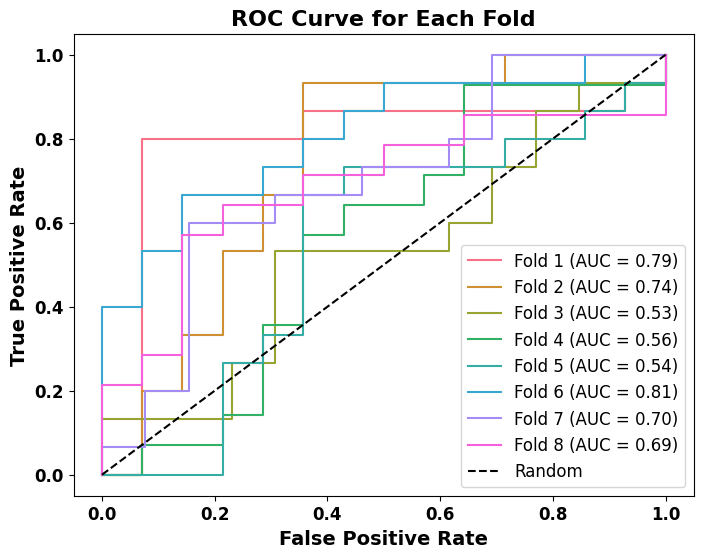

In [27]:
param_grid_logreg = {
    'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    #'classifier__penalty': ['l2'],
    #'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'classifier__solver': ['liblinear']
}

best_model_logreg, grid_result_logreg, _ = train_model(
    X_train, y_train, LogisticRegression, numeric_features, categorical_features, 
    param_grid_logreg, max_iter=5000, cv = 4, nrepeats=2
)

In [28]:
grid_result_logreg

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=4, random_state=42),
             error_score=0,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['REG3A',
                                                                          'XIST',
                                                                          'RPS4Y1',
                                                                          'GSTT1',
                                                                          'XAGE1D',
                                                                          'MYH4',
                                                                          'PLA2G2A',
                                                                          'DLK1',
                                                                          'GSTM1',
                                                                          'CPLX2',
                                                                          'C...
                                                                          'FXYD2',
                                                                          'CYP2E1',
                                                                          'PEG10',
                                                                          'DDX3Y',
                                                                          'EPCAM',
                                                                          'DCAF4L2',
                                                                          'CRP',
                                                                          'AKR1B10',
                                                                          'EEF1A2', ...]),
                                                                        ('passthrough',
                                                                         'passthrough',
                                                                         [])])),
                                       ('classifier',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10,
                                           100],
                         'classifier__penalty': ['l1', 'l2'],
                         'classifier__solver': ['liblinear']},
             return_train_score=True, scoring='accuracy')

In [29]:
best_model_logreg

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['REG3A', 'XIST', 'RPS4Y1',
                                                   'GSTT1', 'XAGE1D', 'MYH4',
                                                   'PLA2G2A', 'DLK1', 'GSTM1',
                                                   'CPLX2', 'CYP3A4', 'SPINK1',
                                                   'CYP2A6', 'MAGEA6', 'APOA4',
                                                   'TSIX', 'REG1A', 'PGC',
                                                   'CYP1A2', 'C9', 'ALDH3A1',
                                                   'FXYD2', 'CYP2E1', 'PEG10',
                                                   'DDX3Y', 'EPCAM', 'DCAF4L2',
                                                   'CRP', 'AKR1B10', 'EEF1A2', ...]),
                                                 ('passthrough', 'passthrough',
                                                  [])])),
                ('classifier',
                 LogisticRegression(C=0.001, random_state=42,
                                    solver='liblinear'))])

In [30]:
print_grid_search_results(best_model = best_model_logreg, grid_result = grid_result_logreg)

Best Parameters: 
 {'classifier__C': 0.001, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'} 

Best Score:
 0.665948275862069


### Evaluate Model on Test Data

In [31]:
# Make predictions on the test data using the best model
y_pred_logreg = best_model_logreg.predict(X_test)

accuracy_score(y_test,y_pred_logreg)

0.5862068965517241

### Classification

In [32]:
generate_classification_report(true_labels = y_test, predicted_labels = y_pred_logreg, 
                                                 model_name="Logistic Regression")


Classification Report (Logistic Regression):
                 precision    recall  f1-score   support

 Long Survival       0.61      0.82      0.70        17
Short Survival       0.50      0.25      0.33        12

      accuracy                           0.59        29
     macro avg       0.55      0.54      0.52        29
  weighted avg       0.56      0.59      0.55        29



### Confusion Matrix Display

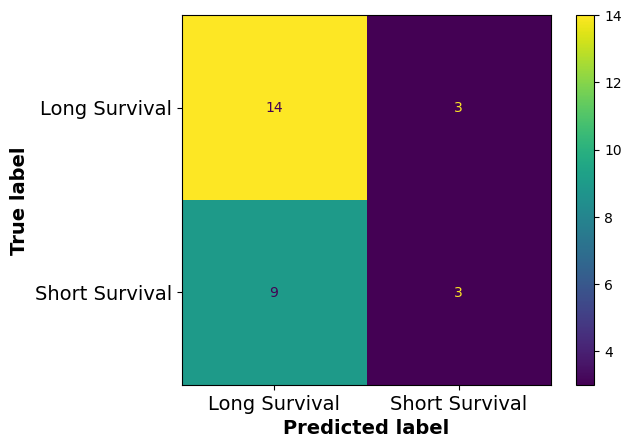

In [33]:
display_confusion_matrix(true_labels = y_test, predicted_labels = y_pred_logreg, 
                                                 model_name="Logistic Regression without Tumor")

### _Logistic with L1_

Remember to increase or decrease cv

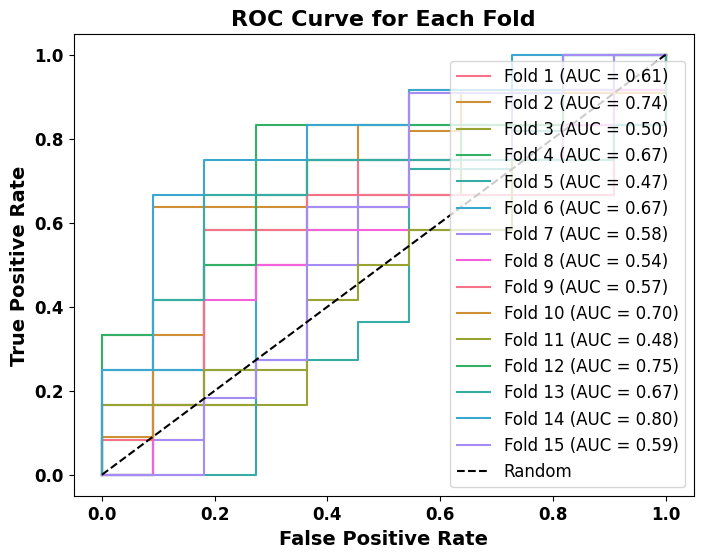

In [34]:
param_grid_logreg1 = {
    'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['liblinear'],
    'classifier__penalty': ['l1']
    # 'classifier__solver': ['lbfgs', 'liblinear', 'newton-cg']
   
}

best_model_logreg1, grid_result_logreg1, _ = train_model(
    X_train, y_train, LogisticRegression, numeric_features, categorical_features, 
    param_grid_logreg1, max_iter=5000, cv = 5, nrepeats= 3
)


In [35]:
best_model_logreg1

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['REG3A', 'XIST', 'RPS4Y1',
                                                   'GSTT1', 'XAGE1D', 'MYH4',
                                                   'PLA2G2A', 'DLK1', 'GSTM1',
                                                   'CPLX2', 'CYP3A4', 'SPINK1',
                                                   'CYP2A6', 'MAGEA6', 'APOA4',
                                                   'TSIX', 'REG1A', 'PGC',
                                                   'CYP1A2', 'C9', 'ALDH3A1',
                                                   'FXYD2', 'CYP2E1', 'PEG10',
                                                   'DDX3Y', 'EPCAM', 'DCAF4L2',
                                                   'CRP', 'AKR1B10', 'EEF1A2', ...]),
                                                 ('passthrough', 'passthrough',
                                                  [])])),
                ('classifier',
                 LogisticRegression(C=0.1, penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [36]:
print_grid_search_results(best_model = best_model_logreg1, grid_result = grid_result_logreg1)

Best Parameters: 
 {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'} 

Best Score:
 0.6197628458498025


In [37]:
selected_features_logreg1 = get_selected_features_from_classifier(best_model_logreg1, features_names)

if selected_features_logreg1:
    print("Selected Features (Logistic Regression):", selected_features_logreg1)
else:
    print("The selected model doesn't have coefficients (not applicable to this classifier).")

Selected Features (Logistic Regression): ['SLC25A47', 'HAO2', 'SERPINA7', 'GFRA1', 'EPO', 'SFN', 'CPZ', 'JCHAIN', 'FAR2P1']


### Evaluate Model on Test Data

In [38]:
# Make predictions on the test data using the best model
y_pred_logreg1 = best_model_logreg1.predict(X_test)

accuracy_score(y_test,y_pred_logreg1)

0.5862068965517241

### Classification

In [39]:
generate_classification_report(true_labels = y_test, predicted_labels = y_pred_logreg1, 
                                                 model_name="Logistic Regression")


Classification Report (Logistic Regression):
                 precision    recall  f1-score   support

 Long Survival       0.63      0.71      0.67        17
Short Survival       0.50      0.42      0.45        12

      accuracy                           0.59        29
     macro avg       0.57      0.56      0.56        29
  weighted avg       0.58      0.59      0.58        29



### Confusion Matrix Display

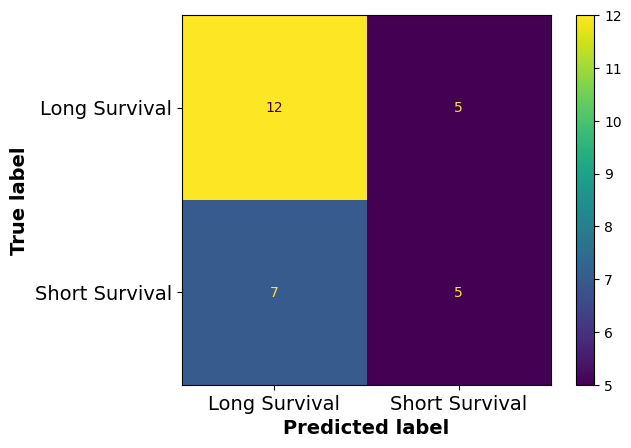

In [40]:
display_confusion_matrix(true_labels = y_test, predicted_labels = y_pred_logreg1, 
                                                 model_name="Logistic Regression")

In [41]:
# # Access the best hyperparameters
# best_params_logreg = grid_result_logreg.best_params_

# # Access the best model
# best_model_logreg = grid_result_logreg.best_estimator_

# # Access the mean cross-validated score for the best model
# best_score_logreg = grid_result_logreg.best_score_

# # Access the results for all parameter combinations
# cv_results_logreg = grid_result_logreg.cv_results_

# test_scores_logreg = cv_results_logreg['split0_test_score'] 

# # Access other information, e.g., training scores
# train_scores_logreg = cv_results_logreg['split0_train_score'] 

# # Print or use the information as needed
# print("Best Hyperparameters (Logistic Regression):", best_params_logreg)
# print("Best Cross-Validated Accuracy (Logistic Regression):", best_score_logreg)
# print("Test Scores for Each Split (Logistic Regression):", test_scores_logreg)
# print("Training Scores for Each Split (Logistic Regression):", train_scores_logreg)


# Stochastic Gradient Descent

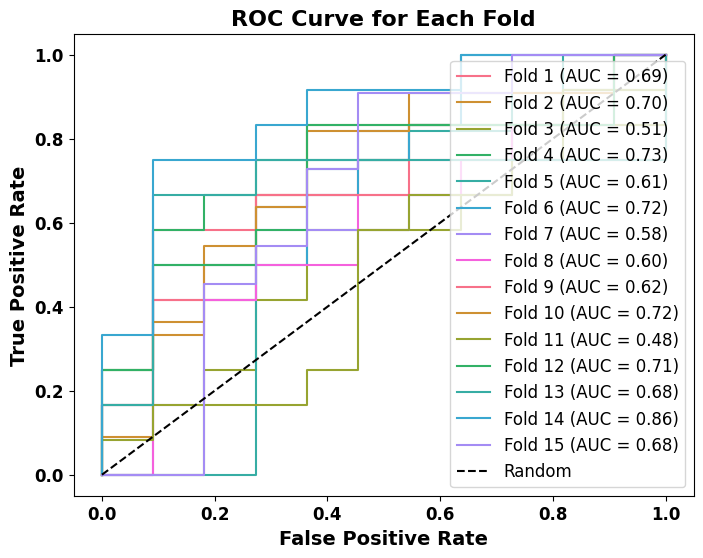

In [42]:
from sklearn.linear_model import SGDClassifier

# Define the parameter grid for SGD
param_grid_sgd = {
    'classifier__loss': ['log_loss', 'modified_huber', 'squared_hinge', 'perceptron'],
    'classifier__penalty': ['elasticnet'],
    'classifier__alpha': [0.0001, 0.001, 0.01, 0.1, 1,2,3],
    'classifier__l1_ratio': [0, 0.1, 0.15, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9, 1], 
}


# Update the model_class parameter in the function call
best_model_sgd, grid_result_sgd, _= train_model(
    X_train, y_train, SGDClassifier, numeric_features, categorical_features, 
    param_grid_sgd, max_iter=5000, cv = 5, nrepeats= 3
)

#Default:: 4, 2 : test:0.48; modified, elastic
# 4,3:  test: 0.51; modified, elastic
#

In [43]:
print_grid_search_results(best_model = best_model_sgd, grid_result = grid_result_sgd)

Best Parameters: 
 {'classifier__alpha': 2, 'classifier__l1_ratio': 0.15, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'elasticnet'} 

Best Score:
 0.6374176548089594


### Selected Genes

In [44]:
selected_features_sgd = get_selected_features_from_classifier(best_model_sgd, features_names)

if selected_features_sgd:
    print("Selected Features (SGD):", selected_features_sgd)
else:
    print("The selected model doesn't have coefficients (not applicable to this classifier).")

Selected Features (SGD): ['PTH2R', 'SLC25A47', 'SLC10A1', 'MAGEC1', 'GREM2', 'PAEP', 'LOC389332', 'CCL21', 'CCL19', 'GFRA1', 'ECEL1', 'EPO', 'DCN', 'CPZ', 'S100A14', 'JCHAIN', 'OGN']


### Evaluate Model on Test Data

In [45]:
# Make predictions on the test data using the best model
y_pred_sgd = best_model_sgd.predict(X_test)

accuracy_score(y_test,y_pred_sgd)

0.5517241379310345

### Classification

In [46]:
generate_classification_report(true_labels = y_test, predicted_labels = y_pred_sgd, 
                                                 model_name="SGD without Tumor")


Classification Report (SGD without Tumor):
                 precision    recall  f1-score   support

 Long Survival       0.61      0.65      0.63        17
Short Survival       0.45      0.42      0.43        12

      accuracy                           0.55        29
     macro avg       0.53      0.53      0.53        29
  weighted avg       0.55      0.55      0.55        29



### Confusion Matrix Display

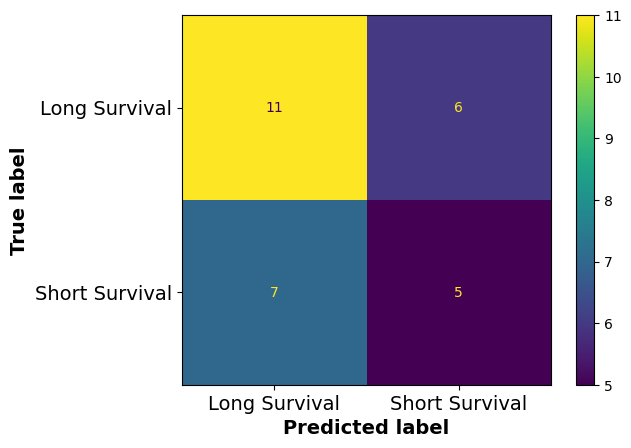

In [47]:
display_confusion_matrix(true_labels = y_test, predicted_labels = y_pred_sgd, 
                                                 model_name="SGD without Tumor")

### _with L1 only_

In [48]:
# from sklearn.linear_model import SGDClassifier

# # Define the parameter grid for SGD
# param_grid_sgd1 = {
#     'classifier__loss': ['log_loss', 'modified_huber'],
#     'classifier__penalty': ['l1'],#['l1', 'l2', 'elasticnet'],
#     'classifier__alpha': [0.0001, 0.001, 0.01, 0.1, 1],
#     #'classifier__max_iter': [1000, 2000, 5000],
# }


# # Update the model_class parameter in the function call
# best_model_sgd1, grid_result_sgd1, _= train_model(
#     X_train, y_train, SGDClassifier, numeric_features, categorical_features, 
#     param_grid_sgd1, max_iter=5000, cv = 5, nrepeats= 3
#)


In [49]:
# print_grid_search_results(best_model = best_model_sgd, grid_result = grid_result_sgd)

### Selected Genes

In [50]:
# selected_features_sgd = get_selected_features_from_classifier(best_model_sgd, features_names)

# if selected_features_sgd:
#     print("Selected Features (SGD):", selected_features_sgd)
# else:
#     print("The selected model doesn't have coefficients (not applicable to this classifier).")

### Evaluate Model on Test Data

In [51]:
# # Make predictions on the test data using the best model
# y_pred_sgd = best_model_sgd.predict(X_test)

# accuracy_score(y_test,y_pred_sgd)

### Classification

In [52]:
# generate_classification_report(true_labels = y_test, predicted_labels = y_pred_sgd, 
#                                                  model_name="Logistic Regression")


### Confusion Matrix Display

In [53]:
# display_confusion_matrix(true_labels = y_test, predicted_labels = y_pred_sgd, 
#                                                  model_name="SGD")

# Including Tumor and Age Quartile

- Ended up not including age-quartile. However, I incoporated it in the training. Just dropped it in the data preprocessing step

In [61]:
X, y, numeric_features, categorical_features, y_mapping = preprocess_data(data = count_new_filtered, 
                                                               target_columns = "recurrence_class", features_to_drop= "age_quartile")#["Tumor_Stage", "age_quartile"])

In [62]:
features_names = X.columns

In [63]:
 # Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)#, stratify=y)

In [64]:
def train_model_tumor_age(X_train, y_train, model_class, numeric_features, 
                categorical_features=None, param_grid=None, max_iter=None, cv=5, nrepeats=3):
    """
    Train a machine learning model using GridSearchCV with cross-validation.

    Parameters:
    - X_train: Training features DataFrame
    - y_train: Training target variable
    - model_class: The model class to be used in the pipeline (e.g., LogisticRegression, RandomForestClassifier)
    - numeric_features: List of numeric feature column names
    - categorical_features: List of categorical feature column names
    - param_grid: Dictionary with hyperparameter values for GridSearchCV
    - cv: Number of folds for cross-validation

    Returns:
    - best_model: Fitted model with the best hyperparameters
    - grid_result: Results of the grid search
    - roc_curves: List of ROC curves for each fold
    """

    # Create transformers based on feature types
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('encoder', OrdinalEncoder(categories=[
            ['T1', 'T2', 'T3', 'T3A', 'T3B', 'T4'],    ## Tumor stage information
            #['16-50', '51-60','61-68','69-90'],     ## Age quatile
            ]))
    ])

    # Create a ColumnTransformer that applies transformers based on feature types
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features) if categorical_features else ('passthrough', 'passthrough', [])
        ]
    )

    # Create a pipeline with the provided model class
    model_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model_class(random_state=42))
    ])

    # StratifiedKFold for cross-validation
    kf = RepeatedStratifiedKFold(n_splits=cv, n_repeats=nrepeats, random_state=42)

    # GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(model_pipeline, param_grid, cv=kf, scoring='accuracy', return_train_score=True, error_score=0, n_jobs=-1)
    grid_result = grid_search.fit(X_train, y_train)

    # Best model from the grid search
    best_model = grid_result.best_estimator_

    # ROC curves for each fold
    roc_curves = []

    plt.figure(figsize=(8, 6))

    for i, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

        # Fit the best model on the training fold
        best_model.fit(X_train_fold, y_train_fold)

        # Check if the model is LinearSVC
        if model_class == LinearSVC:
            # For LinearSVC, use decision_function instead of predict_proba
            decision_values = best_model.decision_function(X_test_fold)
            fpr, tpr, _ = roc_curve(y_test_fold, decision_values)
        else:
            # For other models, use predict_proba
            y_probs = best_model.predict_proba(X_test_fold)[:, 1]
            fpr, tpr, _ = roc_curve(y_test_fold, y_probs)
            
        roc_auc = auc(fpr, tpr)  #calculate roc

        roc_curves.append((fpr, tpr))

        # Plot the ROC curve for the current fold
        plt.plot(fpr, tpr, label=f'Fold {i + 1} (AUC = {roc_auc:.2f})')

    # Plot the random classifier line
    plt.plot([0, 1], [0, 1], 'k--', label='Random')

    # Set plot labels and title
    plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold') 
    plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')   
    plt.title('ROC Curve for Each Fold', fontsize=16, fontweight='bold')  
    plt.xticks(fontsize=12, fontweight='bold') 
    plt.yticks(fontsize=12, fontweight='bold')  
    plt.legend(fontsize=12) 

    plt.legend()

    plt.show()

    return best_model, grid_result, roc_curves


## Logistic Regression + Hyperparameter Tuning + CV 

### _Tune for both L1 and L2_

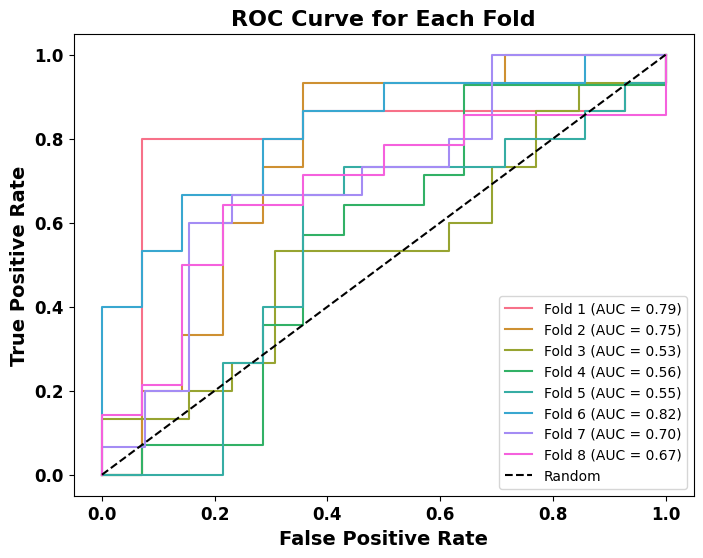

In [65]:
param_grid_logreg_tumor = {
    'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    #'classifier__penalty': ['l2'],
    #'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'classifier__solver': ['liblinear']
}

best_model_logreg_tumor, grid_result_logreg_tumor, _ = train_model_tumor_age(
    X_train, y_train, LogisticRegression, numeric_features, categorical_features, 
    param_grid_logreg_tumor, max_iter=5000, cv = 4, nrepeats=2
)

In [66]:
print_grid_search_results(best_model = best_model_logreg_tumor, grid_result = grid_result_logreg_tumor)

Best Parameters: 
 {'classifier__C': 0.001, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'} 

Best Score:
 0.6570197044334976


### Evaluate Model on Test Data

In [67]:
# Make predictions on the test data using the best model
y_pred_logreg_tumor = best_model_logreg_tumor.predict(X_test)

accuracy_score(y_test,y_pred_logreg_tumor)

0.6206896551724138

### Classification

In [68]:
generate_classification_report(true_labels = y_test, predicted_labels = y_pred_logreg_tumor, 
                                                 model_name="Logistic Regression with Tumor")


Classification Report (Logistic Regression with Tumor):
                 precision    recall  f1-score   support

 Long Survival       0.64      0.82      0.72        17
Short Survival       0.57      0.33      0.42        12

      accuracy                           0.62        29
     macro avg       0.60      0.58      0.57        29
  weighted avg       0.61      0.62      0.60        29



### Confusion Matrix Display

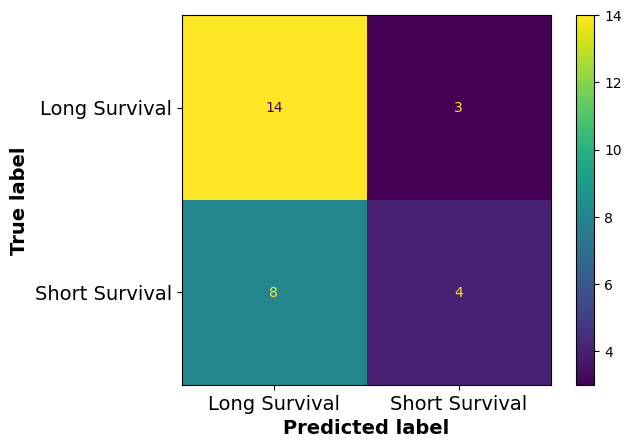

In [69]:
display_confusion_matrix(true_labels = y_test, predicted_labels = y_pred_logreg_tumor, 
                                                 model_name="Logistic Regression with Tumor")

## L1 only

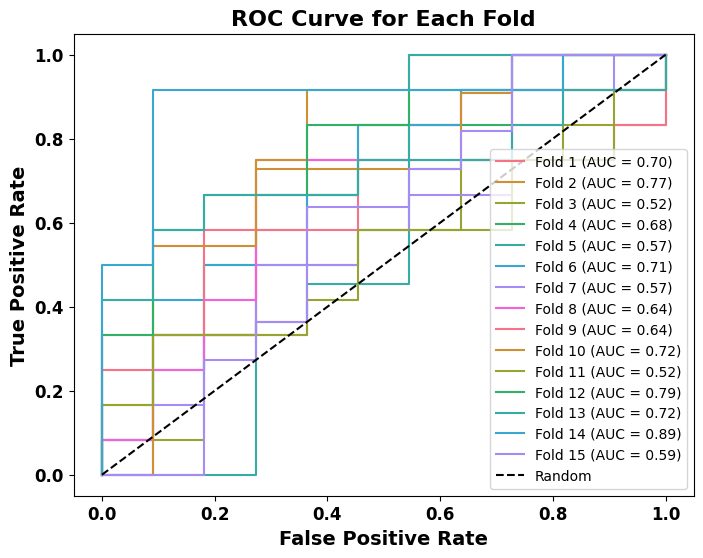

In [70]:
param_grid_logreg1 = {
    'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1'],
    #'classifier__penalty': ['l2'],
    #'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'classifier__solver': ['liblinear']
}

best_model_logreg1, grid_result_logreg1, _ = train_model_tumor_age(
    X_train, y_train, LogisticRegression, numeric_features, categorical_features, 
    param_grid_logreg1, max_iter=5000, cv = 5, nrepeats=3
)

In [71]:
print_grid_search_results(best_model = best_model_logreg1, grid_result = grid_result_logreg1)

Best Parameters: 
 {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'} 

Best Score:
 0.6338603425559948


In [72]:
# Make predictions on the test data using the best model
y_pred_logreg1 = best_model_logreg1.predict(X_test)

accuracy_score(y_test,y_pred_logreg1)

0.6206896551724138

In [73]:
selected_features_logreg1 = get_selected_features_from_classifier(best_model_logreg1, features_names)

if selected_features_logreg1:
    print("Selected Features (LogisticRegression):", selected_features_logreg1)
else:
    print("The selected model doesn't have coefficients (not applicable to this classifier).")

Selected Features (LogisticRegression): ['SLC25A47', 'MAGEC1', 'CCL21', 'SERPINA7', 'GFRA1', 'EPO', 'SFN', 'CPZ', 'JCHAIN', 'Tumor_Stage']


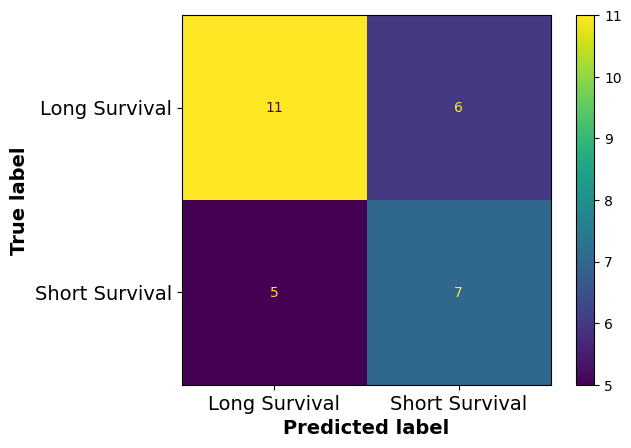

In [86]:
display_confusion_matrix(true_labels = y_test, predicted_labels = y_pred_logreg1, 
                                                 model_name="Logistic Regression with Tumor")

# Stochastic Gradient Descent

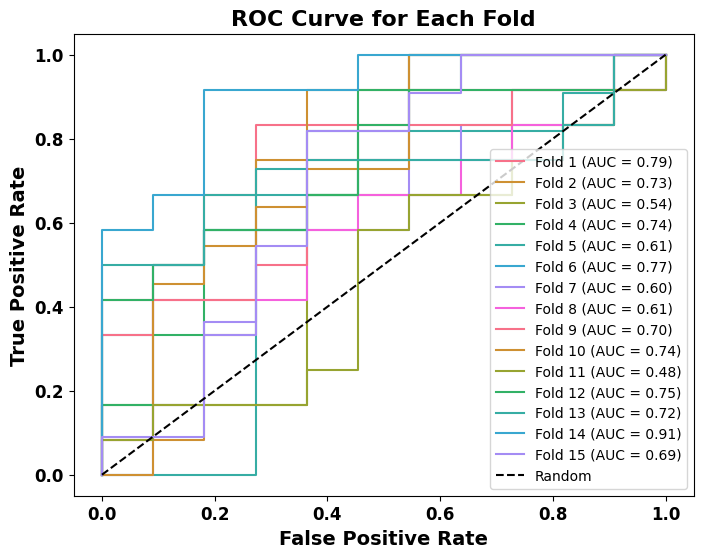

In [74]:
param_grid_sgd1 = {
    'classifier__loss': ['log_loss', 'modified_huber', 'squared_hinge', 'perceptron'],
    'classifier__penalty': ['elasticnet'],
    'classifier__alpha': [0.0001, 0.001, 0.01, 0.1, 1,2,3],
    'classifier__l1_ratio': [0, 0.1, 0.15, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9, 1], 
}



# Update the model_class parameter in the function call
best_model_sgd1, grid_result_sgd1, _= train_model_tumor_age(
    X_train, y_train, SGDClassifier, numeric_features, categorical_features, 
    param_grid_sgd1, max_iter=5000, cv = 5, nrepeats= 3
)

#Default:: 4, 2 : test:0.48; modified, elastic
# 4,3:  test: 0.51; modified, elastic
#

In [75]:
print_grid_search_results(best_model = best_model_sgd1, grid_result = grid_result_sgd1)

Best Parameters: 
 {'classifier__alpha': 3, 'classifier__l1_ratio': 0.1, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'elasticnet'} 

Best Score:
 0.6201581027667984


### Selected Genes

In [76]:
selected_features_sgd1 = get_selected_features_from_classifier(best_model_sgd1, features_names)

if selected_features_sgd1:
    print("Selected Features (SGD):", selected_features_sgd1)
else:
    print("The selected model doesn't have coefficients (not applicable to this classifier).")

Selected Features (SGD): ['CYP2A6', 'CA9', 'PTH2R', 'SLC25A47', 'SLC10A1', 'MAGEC1', 'GREM2', 'PAEP', 'MAGEA2', 'CCL21', 'CCL19', 'EFEMP1', 'GFRA1', 'ECEL1', 'EPO', 'DCN', 'TENM1', 'SFN', 'CPZ', 'S100A14', 'JCHAIN', 'OGN']


### Evaluate Model on Test Data

In [77]:
# Make predictions on the test data using the best model
y_pred_sgd1 = best_model_sgd1.predict(X_test)

accuracy_score(y_test,y_pred_sgd1)

0.5862068965517241

### Classification

In [78]:
generate_classification_report(true_labels = y_test, predicted_labels = y_pred_sgd1, 
                                                 model_name="SGD with Tumor Stage")


Classification Report (SGD with Tumor Stage):
                 precision    recall  f1-score   support

 Long Survival       0.65      0.65      0.65        17
Short Survival       0.50      0.50      0.50        12

      accuracy                           0.59        29
     macro avg       0.57      0.57      0.57        29
  weighted avg       0.59      0.59      0.59        29



### Confusion Matrix Display

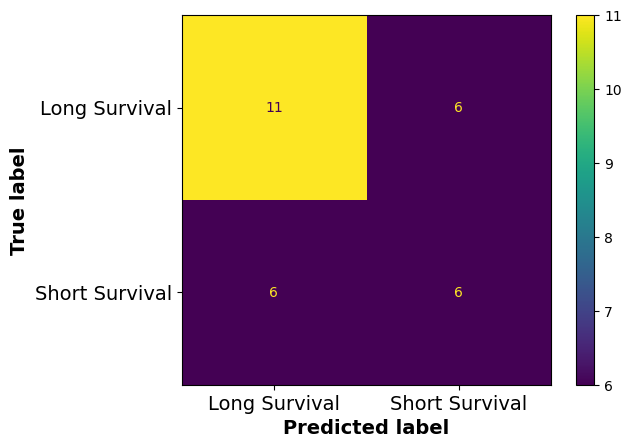

In [79]:
display_confusion_matrix(true_labels = y_test, predicted_labels = y_pred_sgd1, 
                                                 model_name="SGD with Tumor Satge")

## Linear SVM for Classification

In [80]:
# param_grid_linear_svc = {
#     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
#     'classifier__penalty': ['l2'],
#     'classifier__loss': ['hinge', 'squared_hinge'],
#     #'classifier__dual': [True],
# }

# # Update the model_class parameter in the function call
# best_model_linear_svc, grid_result_linear_svc, _ = train_model_tumor_age(
#     X_train, y_train, LinearSVC, numeric_features, categorical_features, 
#     param_grid_linear_svc, max_iter=5000, cv=5, nrepeats=3
# )


In [81]:
# print_grid_search_results(best_model = best_model_linear_svc, grid_result = grid_result_linear_svc)

### Selected Genes

In [82]:
# selected_features_svc = get_selected_features_from_classifier(best_model_linear_svc, features_names)

# if selected_features_svc:
#     print("Selected Features (Linear SVC):", selected_features_svc)
# else:
#     print("The selected model doesn't have coefficients (not applicable to this classifier).")

### Evaluate Model on Test Data

In [83]:
# # Make predictions on the test data using the best model
# y_pred_svc = best_model_linear_svc.predict(X_test)

# accuracy_score(y_test,y_pred_svc)

### Classification

In [84]:
# generate_classification_report(true_labels = y_test, predicted_labels = y_pred_svc
#                                                  model_name="Linear SVC")


### Confusion Matrix Display

In [85]:
# display_confusion_matrix(true_labels = y_test, predicted_labels = y_pred_svc, 
#                                                  model_name="Linear SVC")